Base de Dados: Air Passengers
Para este exercício, usei a base de dados Air Passengers. Ela registra o número de passageiros de companhias aéreas internacionais (em milhares) por mês, cobrindo o período de janeiro de 1949 a dezembro de 1960. É um dataset clássico de séries temporais porque mostra claramente uma tendência de crescimento e uma forte sazonalidade anual.

JUSTIFICATIVA DOS PARÂMETROS

import seaborn as sns e data = sns.load_dataset('flights'): Usei a biblioteca seaborn para carregar o dataset flights. Escolhi essa forma porque é bem mais fácil e confiável, já que o seaborn cuida de encontrar os dados e me livra de ter que me preocupar com links que quebram na internet.

Conversão de year e month para Month como índice: O dataset que o seaborn me deu tinha o ano e o mês em colunas separadas. Eu juntei essas informações para criar uma coluna Month no formato de data, e então a transformei no índice da minha série temporal. Isso é essencial para que os modelos de previsão funcionem direitinho.

data.rename(columns={'passengers': 'Passengers'}, inplace=True): Por fim, só renomeei a coluna principal dos dados (que veio como passengers) para Passengers. Fiz isso para manter o código consistente com o que já tínhamos e para ser mais fácil de usar nas próximas etapas do projeto.

Primeiras 5 linhas da base de dados Air Passengers (via Seaborn):
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

Últimas 5 linhas da base de dados Air Passengers (via Seaborn):
            Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

Formato dos dados: (144, 1)


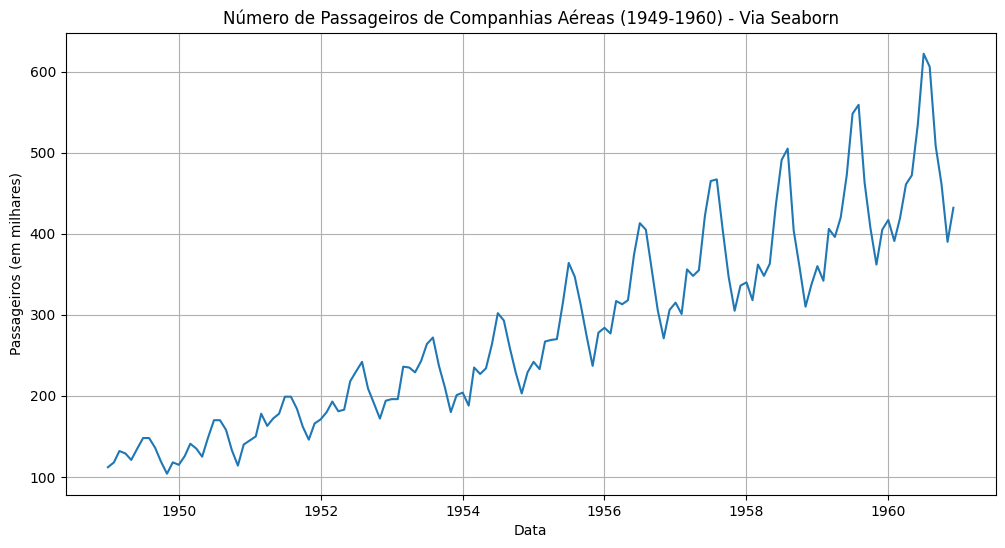

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")




data = sns.load_dataset('flights')

data['Month'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))
data.set_index('Month', inplace=True)
data.drop(['year', 'month'], axis=1, inplace=True)


data.rename(columns={'passengers': 'Passengers'}, inplace=True)



data.index.freq = 'MS'

print("Primeiras 5 linhas da base de dados Air Passengers (via Seaborn):")
print(data.head())
print("\nÚltimas 5 linhas da base de dados Air Passengers (via Seaborn):")
print(data.tail())
print(f"\nFormato dos dados: {data.shape}")


plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'])
plt.title('Número de Passageiros de Companhias Aéreas (1949-1960) - Via Seaborn')
plt.xlabel('Data')
plt.ylabel('Passageiros (em milhares)')
plt.grid(True)
plt.show()

JUSTIFICATIVA DOS PARAMETROS
train_size = len(data) - 12: Eu separei os últimos 12 meses do dataset para serem meus dados de teste. Escolhi 12 meses porque a base de dados tem um ciclo anual (sazonalidade), então testar em um ano completo é importante para ver se meu modelo pega essa repetição.

train_data e test_data: Usei esses comandos para pegar a primeira parte dos dados para treino (train_data) e a última parte para teste (test_data). Assim, simulo uma previsão para o futuro, já que os dados de teste são sempre mais recentes.



Tamanho do conjunto de treinamento: 132 meses
Tamanho do conjunto de teste: 12 meses


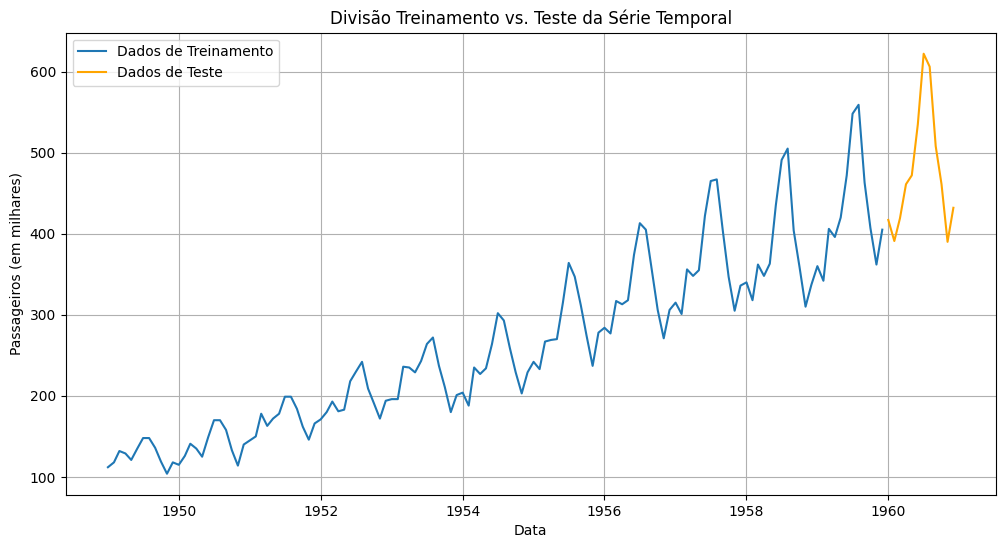

In [6]:

train_size = len(data) - 12
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(f"Tamanho do conjunto de treinamento: {len(train_data)} meses")
print(f"Tamanho do conjunto de teste: {len(test_data)} meses")


plt.figure(figsize=(12, 6))
plt.plot(train_data['Passengers'], label='Dados de Treinamento')
plt.plot(test_data['Passengers'], label='Dados de Teste', color='orange')
plt.title('Divisão Treinamento vs. Teste da Série Temporal')
plt.xlabel('Data')
plt.ylabel('Passageiros (em milhares)')
plt.legend()
plt.grid(True)
plt.show()

Treinamento e teste

Previsão Ingênua (Naïve)

JUSTIFICATIVA DOS PARAMETROS
last_train_value = train_data['Passengers'].iloc[-1]: Com esse comando, pego o número de passageiros do último mês disponível no meu conjunto de treino.

naive_predictions = pd.Series(last_train_value, index=test_data.index): Com esse, eu simplesmente crio uma série de previsões onde todos os meses futuros (do conjunto de teste) recebem esse mesmo último valor que peguei.

Previsões Ingênuas:
Month
1960-01-01    405
1960-02-01    405
1960-03-01    405
1960-04-01    405
1960-05-01    405
Freq: MS, dtype: int64

RMSE (Ingênuo): 102.98
MAE (Ingênuo): 76.00


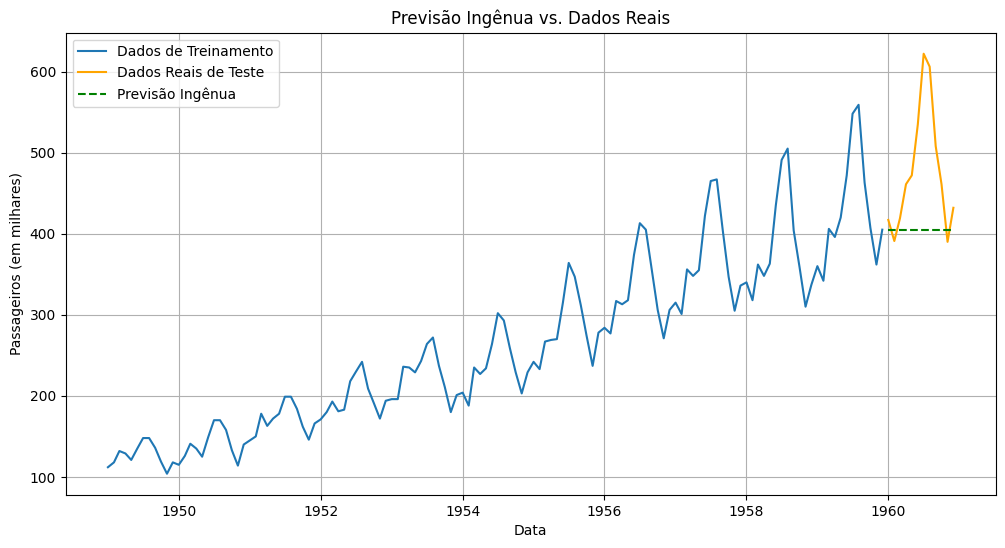

In [7]:

last_train_value = train_data['Passengers'].iloc[-1]
naive_predictions = pd.Series(last_train_value, index=test_data.index)

print("Previsões Ingênuas:")
print(naive_predictions.head())


rmse_naive = np.sqrt(mean_squared_error(test_data['Passengers'], naive_predictions))
mae_naive = mean_absolute_error(test_data['Passengers'], naive_predictions)

print(f"\nRMSE (Ingênuo): {rmse_naive:.2f}")
print(f"MAE (Ingênuo): {mae_naive:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(train_data['Passengers'], label='Dados de Treinamento')
plt.plot(test_data['Passengers'], label='Dados Reais de Teste', color='orange')
plt.plot(naive_predictions, label='Previsão Ingênua', color='green', linestyle='--')
plt.title('Previsão Ingênua vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Passageiros (em milhares)')
plt.legend()
plt.grid(True)
plt.show()

Media movel

JUSTIFICATIVA PARAMETROS
last_train_value = train_data['Passengers'].iloc[-1]: Eu só peguei o último valor de passageiros que tinha nos meus dados de treino.

naive_predictions = pd.Series(last_train_value, index=test_data.index): Com esse valor, eu criei minhas previsões. É bem direto: todos os meses futuros (do meu conjunto de teste) recebem esse mesmo último valor dos dados de treino.


Previsões de Média Móvel (Janela 3):
Month
1960-01-01    391.333333
1960-02-01    391.333333
1960-03-01    391.333333
1960-04-01    391.333333
1960-05-01    391.333333
Freq: MS, dtype: float64

RMSE (Média Móvel, Janela 3): 112.85
MAE (Média Móvel, Janela 3): 85.11


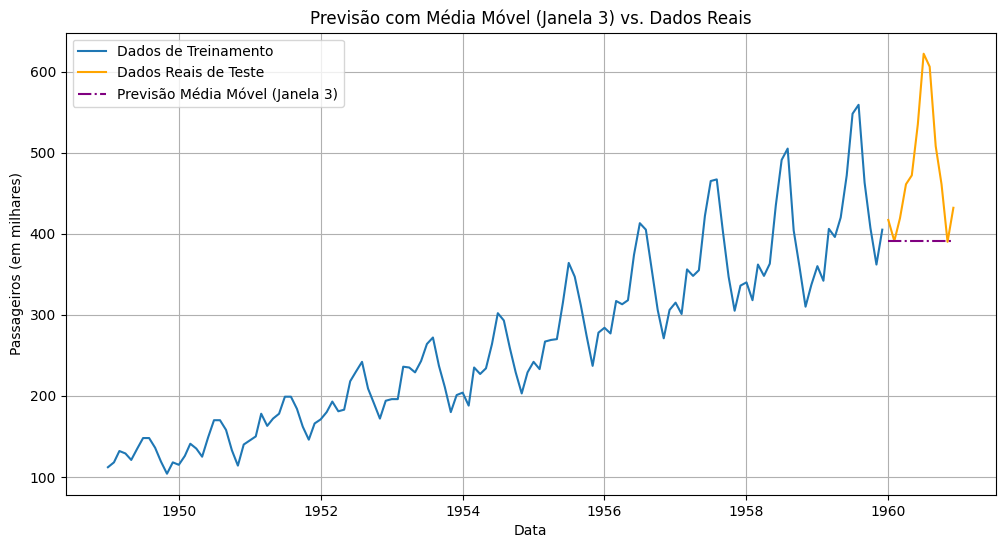

In [8]:
last_train_value = train_data['Passengers'].iloc[-1]: Com esse comando, pego o número de passageiros do último mês disponível no meu conjunto de treino.

naive_predictions = pd.Series(last_train_value, index=test_data.index): Com esse, eu simplesmente crio uma série de previsões onde todos os meses futuros (do conjunto de teste) recebem esse mesmo último valor que peguei.)

Suavização Exponencial Simples

JUSTIFICATIVA PARAMETROS
ses_model = SimpleExpSmoothing(train_data['Passengers'], initialization_method="estimated").fit(): Criei o modelo SES e o "treinei" (.fit()) com meus dados de treino. O parâmetro initialization_method="estimated" faz com que o modelo calcule o melhor valor para o alpha (ou smoothing_level) automaticamente. O alpha é um número entre 0 e 1 que decide o quanto as observações mais recentes importam: um alpha alto dá mais peso ao que aconteceu há pouco tempo.

ses_predictions = ses_model.forecast(len(test_data)): Depois de treinado, usei o método forecast() para gerar as previsões para todo o período do meu conjunto de teste.


Previsões de Suavização Exponencial Simples:
1960-01-01    404.999999
1960-02-01    404.999999
1960-03-01    404.999999
1960-04-01    404.999999
1960-05-01    404.999999
Freq: MS, dtype: float64

RMSE (SES): 102.98
MAE (SES): 76.00


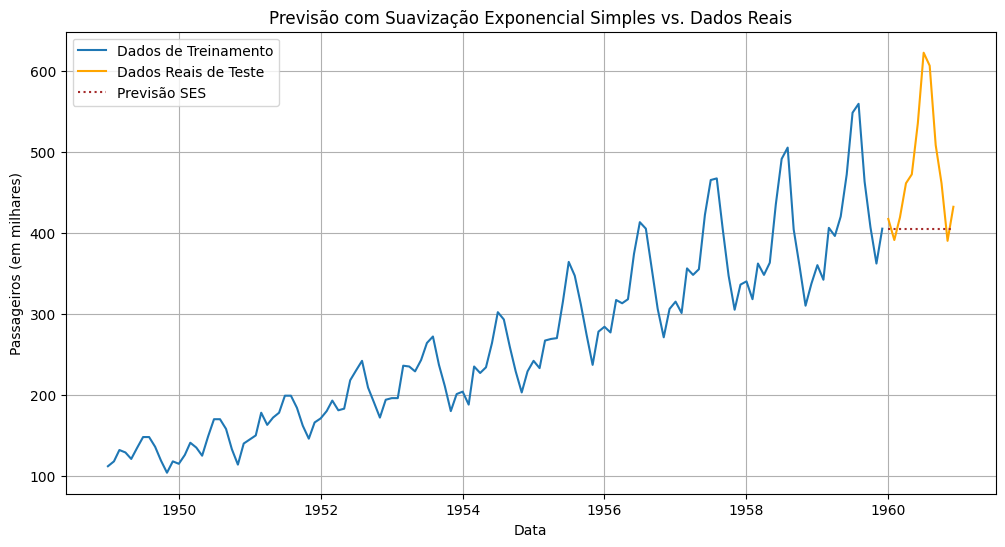

In [9]:
ses_model = SimpleExpSmoothing(train_data['Passengers'], initialization_method="estimated").fit()
ses_predictions = ses_model.forecast(len(test_data))

print("\nPrevisões de Suavização Exponencial Simples:")
print(ses_predictions.head())


rmse_ses = np.sqrt(mean_squared_error(test_data['Passengers'], ses_predictions))
mae_ses = mean_absolute_error(test_data['Passengers'], ses_predictions)

print(f"\nRMSE (SES): {rmse_ses:.2f}")
print(f"MAE (SES): {mae_ses:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train_data['Passengers'], label='Dados de Treinamento')
plt.plot(test_data['Passengers'], label='Dados Reais de Teste', color='orange')
plt.plot(ses_predictions, label='Previsão SES', color='brown', linestyle=':')
plt.title('Previsão com Suavização Exponencial Simples vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Passageiros (em milhares)')
plt.legend()
plt.grid(True)
plt.show()

comparação


--- Resumo das Métricas de Previsão ---
Modelo                    | RMSE       | MAE       
--------------------------------------------------
Ingênuo (Baseline)        | 102.98     | 76.00     
Média Móvel (Janela 3)    | 112.85     | 85.11     
SES                       | 102.98     | 76.00     


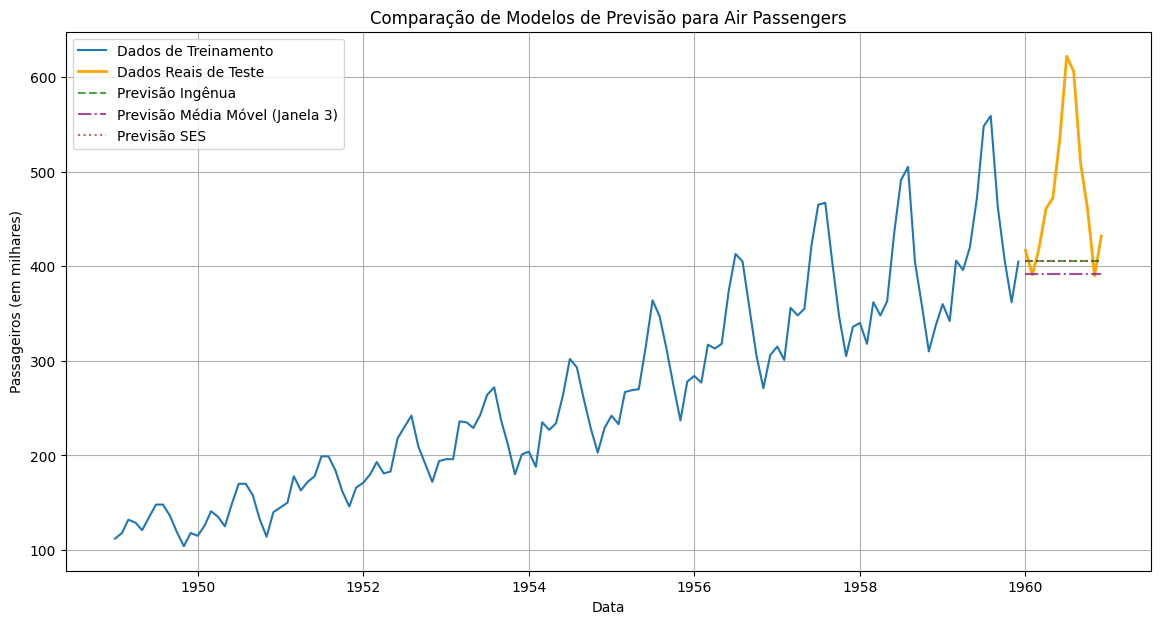

In [10]:
print("\n--- Resumo das Métricas de Previsão ---")
print(f"{'Modelo':<25} | {'RMSE':<10} | {'MAE':<10}")
print("-" * 50)
print(f"{'Ingênuo (Baseline)':<25} | {rmse_naive:<10.2f} | {mae_naive:<10.2f}")
print(f"{'Média Móvel (Janela 3)':<25} | {rmse_ma:<10.2f} | {mae_ma:<10.2f}")
print(f"{'SES':<25} | {rmse_ses:<10.2f} | {mae_ses:<10.2f}")


plt.figure(figsize=(14, 7))
plt.plot(train_data['Passengers'], label='Dados de Treinamento')
plt.plot(test_data['Passengers'], label='Dados Reais de Teste', color='orange', linewidth=2)
plt.plot(naive_predictions, label='Previsão Ingênua', color='green', linestyle='--', alpha=0.7)
plt.plot(ma_forecast, label='Previsão Média Móvel (Janela 3)', color='purple', linestyle='-.', alpha=0.7)
plt.plot(ses_predictions, label='Previsão SES', color='brown', linestyle=':', alpha=0.7)
plt.title('Comparação de Modelos de Previsão para Air Passengers')
plt.xlabel('Data')
plt.ylabel('Passageiros (em milhares)')
plt.legend()
plt.grid(True)
plt.show()